In [2]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import pdb
import copy
from scipy import sparse
import anndata
import cerberus
import subprocess
from pandarallel import pandarallel

p = os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

In [3]:
major_set = '../swan/isos_sample_gene_90.tsv'
c_annot = 'cerberus_annot_triplets.h5'
gtf = '../cerberus.gtf'
swan_file = '../swan/swan.p'
filt_ab = '../cerberus_filtered_abundance.tsv'
h5 = '../cerberus_annot.h5'

fig_dir = '/Users/fairliereese/mortazavi_lab/documents/rnawg/fig_obs_vs_sample_det_centroid/'

In [4]:
sg = swan.read(swan_file)
ca = cerberus.read(c_annot)

Read in graph from ../swan/swan.p


In [5]:
def get_centroid_df(ca, source):
    
    keep_cols = ['gname', 'gid', 'n_tss', 'n_ic', 'n_tes', 'splicing_ratio', 'tss_ratio', 'tes_ratio', 'spl_ratio', 'n_iso', 'source']
    
    # compute centroid for each  sample / gene pairing for the different sources
    df = ca.triplets.loc[(ca.triplets.source == source)].copy(deep=True)
    df = cerberus.compute_simplex_coords(df, 'splicing_ratio')
    df = df[keep_cols]
    df = df.groupby(['gname', 'gid', 'source']).mean().reset_index()
    df = assign_sector(df)   
    
    # only protein coding genes
    gene_df, _, _ = get_gtf_info(how='gene', ver='v40_cerberus', add_stable_gid=True)
    gene_df = gene_df[['gid_stable', 'biotype']]
    df = df.merge(gene_df, how='left', left_on='gid', right_on='gid_stable')
    df = df.loc[df.biotype=='protein_coding']   
    
    return df

In [6]:
df_det = get_centroid_df(ca, 'sample_det')

# obs_det -- only keep genes that have > 1 isoform total 
df_obs = ca.triplets.loc[ca.triplets.source == 'obs_det'].copy(deep=True)
df_obs = df_obs.loc[df_obs.n_iso>1]

# merge
print(len(df_det.index))
print(len(df_obs.index))
df = df_det.merge(df_obs, how='inner', on=['gid', 'gname'], suffixes=('_det', '_obs_det'))
print(len(df.index))


17523
18148
15740


In [7]:
# compute distances
pandarallel.initialize(nb_workers=8, verbose=1)
df['dist'] = df.parallel_apply(simplex_dist,
                               args=('_det', '_obs_det'),
                               axis=1)

# get rid of the pesky null guys
cols = ['gname', 'sample', 'dist', 'n_iso_det', 'tss_ratio_det', 'spl_ratio_det', 'tes_ratio_det', 'n_iso_obs_det', 'tss_ratio_obs_det', 'spl_ratio_obs_det', 'tes_ratio_obs_det']
df.loc[df.dist.isnull()][cols]
df = df.loc[~df.dist.isnull()]

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/scipy/spatial/distance.py:1300: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(js / 2.0)
/Users/fairliereese/miniconda3/lib/python3.7/site-packages/scipy/spatial/distance.py:1300: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(js / 2.0)


In [8]:
df['z_score'] = st.zscore(df.dist.tolist())

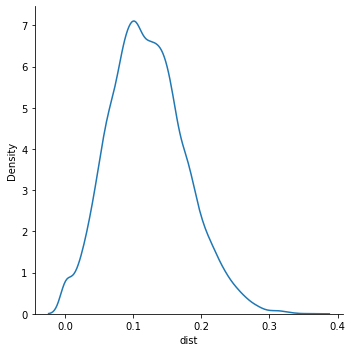

In [9]:
sns.displot(df, x='dist', kind='kde')

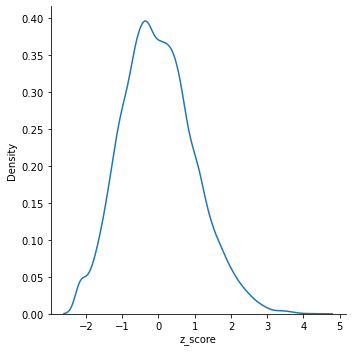

In [10]:
sns.displot(df, x='z_score', kind='kde')

In [11]:
df.to_csv('obs_vs_sample_det_centroid_dists.tsv', sep='\t', index=False)

## Simplex and browser plots for individual genes

In [12]:
# add centroids to triplets
df_det['source'] = 'sample_det_centroid'
ca.triplets = pd.concat([ca.triplets, df_det], axis=0)

In [231]:
def plot_simplex_here(ca, gene, density=False, opref='figures/'):
    # det
    c_dict, order = get_biosample_colors()
    c_dict[np.nan] = 'k'
    mmap = {'v40': '*', 'v29': 'x', 'obs_det': '^', 'cerberus': '2', 'sample_det_centroid': 'x'} 
    subset = {'source': ['v40', 'obs_det', 'sample_det', 'sample_det_centroid']}
    fname='{}/simplex_{}_det.pdf'.format(opref, gene.lower())
    if not density:
        df = ca.plot_simplex(top='splicing_ratio', 
                    gene=gene,
                    hue='sample',
                    cmap=c_dict,
                    # density=True,
                    # density_scale=50,
                    # density_cmap='Purples',
                    size='gene_tpm', 
                    log_size=True,
                    sectors=True,
                    marker_style='source',
                    mmap=mmap,
                    legend=False,
                    jitter=True,
                    subset=subset,
                    size_scale=0.5,
                    fname=fname)
    else:
        df = ca.plot_simplex(top='splicing_ratio', 
                gene=gene,
                hue='sample',
                cmap=c_dict,
                density=True,
                density_scale=50,
                density_cmap='Purples',
                size='gene_tpm', 
                log_size=True,
                sectors=True,
                marker_style='source',
                mmap=mmap,
                legend=False,
                jitter=True,
                subset=subset,
                size_scale=0.5,
                fname=fname) 
    print(df.source.unique())

In [ ]:
df = pd.read_csv('obs_vs_sample_det_centroid_dists.tsv', sep='\t')

In [86]:
# how many genes have zscore > 2?
n = len(df.index)
n_num = len(df.loc[df.z_score > 2].index)
print(f'{(n_num/n)*100:.2f}% ({n_num}/{n}) of protein-coding genes w/ >1 isoform have z-score > 2')


3.21% (505/15738) of protein-coding genes w/ >1 isoform have z-score > 2


In [82]:
df.columns

Index(['gname', 'gid', 'source_det', 'n_tss_det', 'n_ic_det', 'n_tes_det',
       'splicing_ratio_det', 'tss_ratio_det', 'tes_ratio_det', 'spl_ratio_det',
       'n_iso_det', 'sector', 'gid_stable', 'biotype', 'source_obs_det',
       'n_tss_obs_det', 'n_tes_obs_det', 'n_ic_obs_det', 'n_iso_obs_det',
       'splicing_ratio_obs_det', 'tss_ratio_obs_det', 'tes_ratio_obs_det',
       'spl_ratio_obs_det', 'sample', 'gene_tpm', 'dist', 'z_score'],
      dtype='object')

In [84]:
df.loc[df.gname=='ACTA1'][['n_tss_det', 'n_tes_det', 'splicing_ratio_det']]

n_tss_det  n_tes_det  splicing_ratio_det
179        1.0        1.0            2.894737

In [43]:
df.sort_values(by='dist', ascending=False).head(20)[['gname', 'tss_ratio_det', 'spl_ratio_det', 'tes_ratio_det',
                                                     'tss_ratio_obs_det', 'spl_ratio_obs_det', 'tes_ratio_obs_det', 'dist']]

gname  tss_ratio_det  spl_ratio_det  tes_ratio_det  tss_ratio_obs_det  \
179     ACTA1       0.283798       0.432405       0.283798           0.050000   
11067    RGP1       0.307969       0.281033       0.410999           0.108434   
9048   NUFIP2       0.279224       0.266207       0.454569           0.074286   
2341    CEBPA       0.424197       0.272436       0.303367           0.848485   
14615   USP33       0.161016       0.570033       0.268951           0.505618   
3646    DMTF1       0.278772       0.502993       0.218234           0.478589   
4066   EIF4A2       0.145035       0.718011       0.136955           0.328767   
7540   MAN2C1       0.238293       0.527947       0.233760           0.415020   
1455     BRD8       0.142466       0.669889       0.187644           0.354839   
5654      GSC       0.320802       0.313283       0.365915           0.157895   
13866   TMTC3       0.303752       0.271467       0.424781           0.105882   
12911  STARD3       0.209281       0.573129       0.217590           0.452830   
3337   DALRD3       0.150487       0.723654       0.125859           0.571429   
7971   MMADHC       0.180678       0.563729       0.255593           0.114754   
3307   CYP7B1       0.319426       0.305812       0.374762           0.157895   
15356  ZNF346       0.174094       0.573165       0.252741           0.163934   
61      ABCF3       0.213337       0.526098       0.260565           0.312500   
10329  PRKAA2       0.294143       0.253610       0.452247           0.121212   
11881   SF3B2       0.155803       0.615869       0.228329           0.269663   
6465     IPO7       0.293763       0.252031       0.454205           0.121212   

       spl_ratio_obs_det  tes_ratio_obs_det      dist  
179             0.900000           0.050000  0.363736  
11067           0.024096           0.867470  0.360800  
9048            0.034286           0.891429  0.344301  
2341            0.030303           0.121212  0.334538  
14615           0.157303           0.337079  0.332972  
3646            0.090680           0.430730  0.331555  
4066            0.260274           0.410959  0.331405  
7540            0.110672           0.474308  0.327179  
1455            0.219355           0.425806  0.327035  
5654            0.052632           0.789474  0.324564  
13866           0.047059           0.847059  0.323029  
12911           0.150943           0.396226  0.318952  
3337            0.346939           0.081633  0.318835  
7971            0.196721           0.688525  0.318478  
3307            0.052632           0.789474  0.318047  
15356           0.180328           0.655738  0.316514  
61              0.125000           0.562500  0.315409  
10329           0.030303           0.848485  0.315285  
11881           0.191011           0.539326  0.314615  
6465            0.030303           0.848485  0.313889

['v40' 'obs_det' 'sample_det' 'sample_det_centroid']


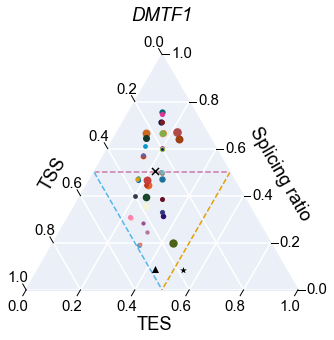

In [15]:
plot_simplex_here(ca, 'DMTF1')

In [16]:
# ca.triplets.loc[(ca.triplets.gname=='DMTF1')&(ca.triplets.source=='sample_det')&(ca.triplets.spl_ratio>=0.5)]

In [17]:
# ca.triplets.loc[(ca.triplets.gname=='DMTF1')&(ca.triplets.source=='sample_det')&(ca.triplets.spl_ratio<0.5)]

Calculating iso TPM values
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1817: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1816: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # isos detected: 234040
# isos >= 1 tpm: 212911
Applying gene type and novelty subset
Number of isos reported: 209476
Found 50 total samples
small text size: 20.3
big text size: 17.571194762684122


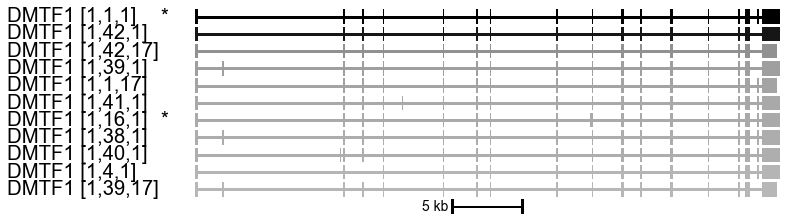

In [18]:
gene = 'DMTF1'
obs_col = 'sample'
obs_condition = 'h9'
ax, tpm_df = plot_browser_isos(ca, sg, gene,
                                         obs_col, obs_condition,
                                         filt_ab, major_set,
                                         h_space=0.24,
                                         h=0.2, ref_source='v40',
                                         major=False)

Calculating iso TPM values
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1817: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1816: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # isos detected: 234040
# isos >= 1 tpm: 212911
Applying gene type and novelty subset
Number of isos reported: 209476
Found 50 total samples
small text size: 20.3
big text size: 17.571194762684122


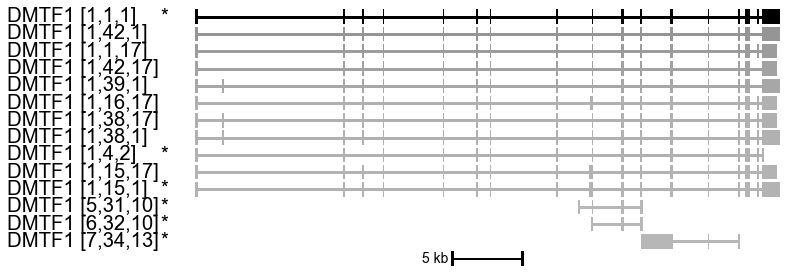

In [47]:
gene = 'DMTF1'
obs_col = 'sample'
obs_condition = 'h9_panc_progen'
ax, tpm_df = plot_browser_isos(ca, sg, gene,
                                         obs_col, obs_condition,
                                         filt_ab, major_set,
                                         h_space=0.24,
                                         h=0.2, ref_source='v40',
                                         major=False)

Calculating iso TPM values
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 234040
# isos >= 1 tpm: 212911
Applying gene type and novelty subset
Number of isos reported: 209476
Found 50 total samples
small text size: 20.3
big text size: 17.571194762684122


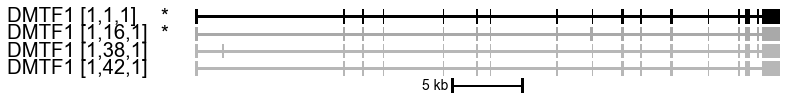

In [48]:
gene = 'DMTF1'
obs_col = 'sample'
obs_condition = 'h9_panc_beta'
ax, tpm_df = plot_browser_isos(ca, sg, gene,
                                         obs_col, obs_condition,
                                         filt_ab, major_set,
                                         h_space=0.24,
                                         h=0.2, ref_source='v40',
                                         major=False)

['v40' 'obs_det' 'sample_det' 'sample_det_centroid']


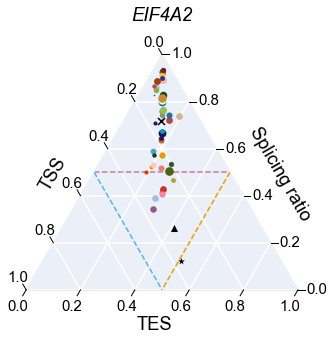

In [19]:
plot_simplex_here(ca, 'EIF4A2')

['v40' 'obs_det' 'sample_det' 'sample_det_centroid']


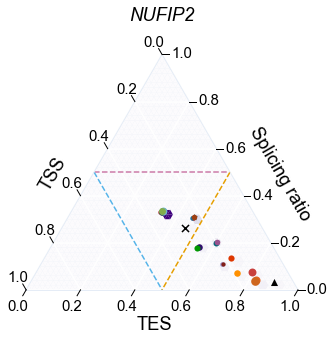

In [30]:
plot_simplex_here(ca, 'NUFIP2', density=True)

In [21]:
# ca.triplets.loc[(ca.triplets.gname=='NUFIP2')&(ca.triplets.source=='sample_det')&(ca.triplets.tes_ratio>=0.5)]

In [22]:
# ca.triplets.loc[(ca.triplets.gname=='NUFIP2')&(ca.triplets.source=='sample_det')&(ca.triplets.tes_ratio<0.5)]

['v40' 'obs_det' 'sample_det' 'sample_det_centroid']


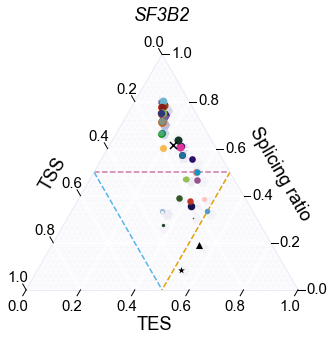

In [35]:
plot_simplex_here(ca, 'SF3B2', density=True)


['v40' 'obs_det' 'sample_det']


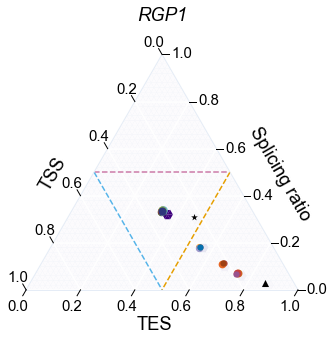

In [45]:
plot_simplex_here(ca, 'RGP1', density=True)

In [24]:
# ca.triplets.loc[(ca.triplets.gname=='RGP1')&(ca.triplets.source=='sample_det')&(ca.triplets.tes_ratio>=0.5)].sort_values(by='tes_ratio', ascending=False)

In [32]:
# ca.triplets.loc[(ca.triplets.gname=='RGP1')&(ca.triplets.source=='sample_det')]

Calculating iso TPM values
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1817: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1816: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # isos detected: 234040
# isos >= 1 tpm: 212911
Applying gene type and novelty subset
Number of isos reported: 209476
Found 50 total samples
small text size: 20.3
big text size: 17.571194762684122


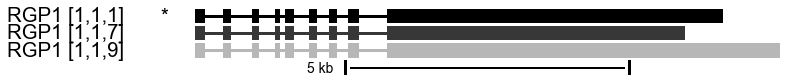

In [32]:
gene = 'RGP1'
obs_col = 'sample'
obs_condition = 'h1'
ax, tpm_df = plot_browser_isos(ca, sg, gene,
                                         obs_col, obs_condition,
                                         filt_ab, major_set,
                                         h_space=0.24,
                                         h=0.2, ref_source='v40',
                                         major=False)

Calculating iso TPM values
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 234040
# isos >= 1 tpm: 212911
Applying gene type and novelty subset
Number of isos reported: 209476
Found 50 total samples
small text size: 20.3
big text size: 17.571194762684122


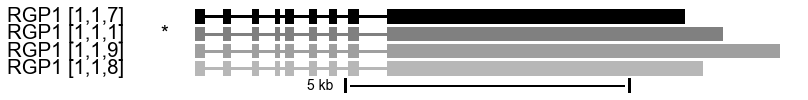

In [33]:
gene = 'RGP1'
obs_col = 'sample'
obs_condition = 'h1_de'
ax, tpm_df = plot_browser_isos(ca, sg, gene,
                                         obs_col, obs_condition,
                                         filt_ab, major_set,
                                         h_space=0.24,
                                         h=0.2, ref_source='v40',
                                         major=False)

['v40' 'obs_det' 'sample_det' 'sample_det_centroid']


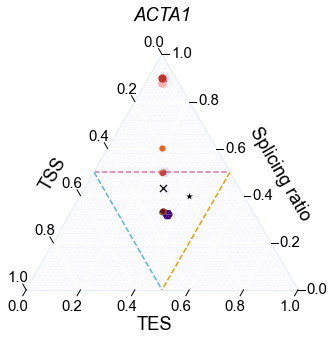

In [232]:
plot_simplex_here(ca, 'ACTA1', density=True, opref=fig_dir)

In [57]:
ca.triplets.loc[(ca.triplets.source.isin(['sample_det', 'obs_det', 'sample_det_centroid']))&(ca.triplets.gname=='ACTA1')].sort_values(by='gene_tpm', ascending=False)[['source', 'n_tss', 'n_ic', 'n_tes', 'splicing_ratio', 'n_iso',
                                                                                  'tss_ratio', 'spl_ratio', 'tes_ratio',
                                                                                  'sample', 'gene_tpm']]

source  n_tss  n_ic  n_tes  splicing_ratio      n_iso  \
285141           sample_det    1.0  15.0    1.0            15.0  15.000000   
393110           sample_det    1.0  18.0    1.0            18.0  18.000000   
503285           sample_det    1.0   1.0    1.0             1.0   1.000000   
230334           sample_det    1.0   3.0    1.0             3.0   3.000000   
156231           sample_det    1.0   2.0    1.0             2.0   2.000000   
143654           sample_det    1.0   1.0    1.0             1.0   1.000000   
214304           sample_det    1.0   2.0    1.0             2.0   2.000000   
344695           sample_det    1.0   2.0    1.0             2.0   2.000000   
596810           sample_det    1.0   1.0    1.0             1.0   1.000000   
5868             sample_det    1.0   1.0    1.0             1.0   1.000000   
409459           sample_det    1.0   1.0    1.0             1.0   1.000000   
19906            sample_det    1.0   1.0    1.0             1.0   1.000000   
528487           sample_det    1.0   1.0    1.0             1.0   1.000000   
585201           sample_det    1.0   1.0    1.0             1.0   1.000000   
540423           sample_det    1.0   1.0    1.0             1.0   1.000000   
308262           sample_det    1.0   1.0    1.0             1.0   1.000000   
190358           sample_det    1.0   1.0    1.0             1.0   1.000000   
444820           sample_det    1.0   1.0    1.0             1.0   1.000000   
62594            sample_det    1.0   1.0    1.0             1.0   1.000000   
8074                obs_det    1.0  18.0    1.0            18.0  18.000000   
213     sample_det_centroid    NaN   NaN    NaN             NaN   2.894737   

        tss_ratio  spl_ratio  tes_ratio              sample      gene_tpm  
285141   0.058824   0.882353   0.058824              muscle  12631.827148  
393110   0.050000   0.900000   0.050000               heart   5266.510254  
503285   0.333333   0.333333   0.333333                  h9    140.497406  
230334   0.200000   0.600000   0.200000                  h1     81.040436  
156231   0.250000   0.500000   0.250000               h9_de     55.909203  
143654   0.333333   0.333333   0.333333          pgp1_astro     36.729740  
214304   0.250000   0.500000   0.250000             vessels     30.072628  
344695   0.250000   0.500000   0.250000               h1_de     16.969566  
596810   0.333333   0.333333   0.333333               hepg2      9.841464  
5868     0.333333   0.333333   0.333333               caco2      9.697802  
409459   0.333333   0.333333   0.333333                pgp1      7.116783  
19906    0.333333   0.333333   0.333333               brain      3.949811  
528487   0.333333   0.333333   0.333333          h9_chondro      3.336852  
585201   0.333333   0.333333   0.333333        h9_panc_beta      3.181416  
540423   0.333333   0.333333   0.333333  pgp1_excite_neuron      2.242642  
308262   0.333333   0.333333   0.333333               wtc11      1.935322  
190358   0.333333   0.333333   0.333333      h9_panc_progen      1.552479  
444820   0.333333   0.333333   0.333333           pgp1_endo      1.549036  
62594    0.333333   0.333333   0.333333                lung      0.448043  
8074     0.050000   0.900000   0.050000                 NaN           NaN  
213      0.283798   0.432405   0.283798                 NaN           NaN

19


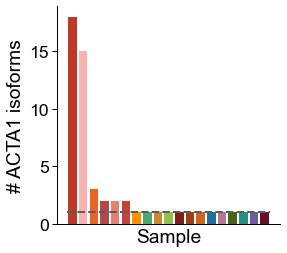

In [233]:
temp = ca.triplets.loc[(ca.triplets.source.isin(['sample_det']))&(ca.triplets.gname=='ACTA1')].sort_values(by='n_iso', ascending=False)

c_dict, order = get_biosample_colors()
sns.set_context('paper', font_scale=2)
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
plt.figure(figsize=(4,4))

order = temp['sample'].tolist()
print(len(order))
ax = sns.barplot(temp, y='n_iso', x='sample', palette=c_dict, order=order, saturation=1)
_ = plt.xticks([], [])
_ = ax.set(xlabel='Sample', ylabel='# ACTA1 isoforms')

# add hline at 1
xlims = ax.get_xlim()
color = '#5c5c5c'
ax.hlines(1, xlims[0], xlims[1],
              colors=color, linestyles='dashed',
              linewidth=2)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fname = f'{fig_dir}/acta1_isos_per_sample_bar.pdf'
plt.savefig(fname, dpi=500, bbox_inches='tight')


# ax = sns.swarmplot(temp, y='n_iso', hue='sample', palette=c_dict, size=12)
# ax.get_legend().remove()
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# _ = plt.yticks(np.arange(1, 19))

# sns.displot(temp, x='n_iso', kind='hist', discrete=True, binwidth=1, linewidth=0)


In [ ]:
ca.triplets.loc[(ca.triplets.gname=='ACTA1')&(ca.triplets.source=='sample_det')]

Calculating iso TPM values
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1854: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1853: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # isos detected: 234040
# isos >= 1 tpm: 212911
Applying gene type and novelty subset
Number of isos reported: 209476
Found 50 total samples
small text size: 20.3
big text size: 17.571194762684122
/Users/fairliereese/mortazavi_lab/documents/rnawg/fig_obs_vs_sample_det_centroid//ACTA1_sample_browser.pdf


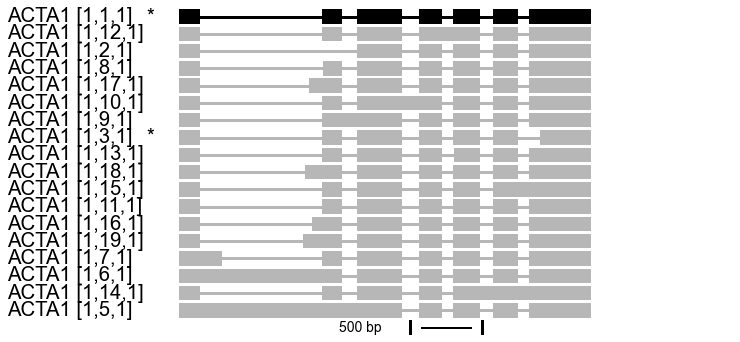

In [4]:
gene = 'ACTA1'
obs_col = 'sample'
obs_condition = 'heart'
ax, tpm_df = plot_browser_isos(ca, sg, gene,
                                         obs_col, obs_condition,
                                         filt_ab, major_set,
                                         h_space=0.24,
                                         h=0.2, ref_source='v40',
                                         major=False)
fname = f'{fig_dir}/{gene}_{obs_col}_browser.pdf'
print(fname)
plt.savefig(f'{fig_dir}/{gene}_{obs_col}_browser.pdf', dpi=300)


Calculating iso TPM values
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 234040
# isos >= 1 tpm: 212911
Applying gene type and novelty subset
Number of isos reported: 209476
Found 50 total samples
small text size: 20.3
big text size: 17.571194762684122


NameError: name 'sample' is not defined

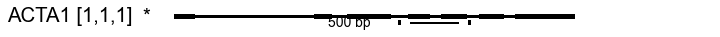

In [131]:
gene = 'ACTA1'
obs_col = 'sample'
obs_condition = 'h9'
ax, tpm_df = plot_browser_isos(ca, sg, gene,
                                         obs_col, obs_condition,
                                         filt_ab, major_set,
                                         h_space=0.24,
                                         h=0.2, ref_source='v40',
                                         major=False)
plt.savefig(f'{fig_dir}/{gene}_{obs_col}_browser.pdf', dpi=300)


Calculating iso TPM values
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 234040
# isos >= 1 tpm: 212911
Applying gene type and novelty subset
Number of isos reported: 209476
Found 50 total samples
small text size: 20.3
big text size: 17.571194762684122


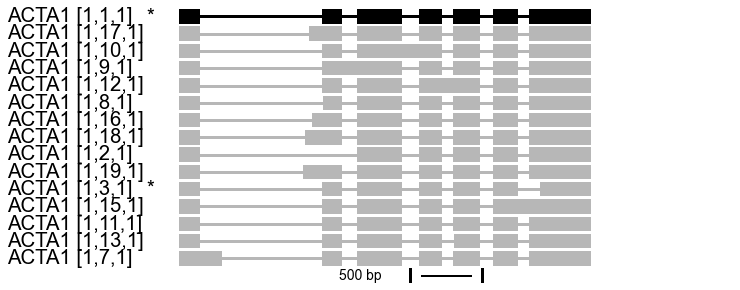

In [7]:
gene = 'ACTA1'
obs_col = 'sample'
obs_condition = 'muscle'
ax, tpm_df = plot_browser_isos(ca, sg, gene,
                                         obs_col, obs_condition,
                                         filt_ab, major_set,
                                         h_space=0.24,
                                         h=0.2, ref_source='v40',
                                         major=False)

['v40' 'obs_det' 'sample_det' 'sample_det_centroid']


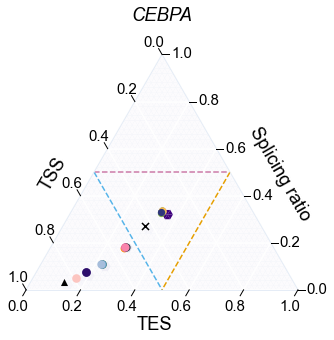

In [34]:
plot_simplex_here(ca, 'CEBPA', density=True)

In [128]:
ca.triplets.loc[(ca.triplets.source.isin(['sample_det', 'obs_det', 'sample_det_centroid']))&(ca.triplets.gname=='CEBPA')].sort_values(by='tss_ratio', ascending=False)[['source', 'n_tss', 'n_ic', 'n_tes', 'splicing_ratio', 'n_iso',
                                                                                  'tss_ratio', 'spl_ratio', 'tes_ratio',
                                                                                  'sample', 'gene_tpm']]

source  n_tss  n_ic  n_tes  splicing_ratio  n_iso  tss_ratio  \
22325      obs_det    7.0   1.0    1.0        0.250000    7.0   0.848485   
337056  sample_det    5.0   1.0    1.0        0.333333    5.0   0.789474   
71286   sample_det    4.0   1.0    1.0        0.400000    4.0   0.740741   
602997  sample_det    4.0   1.0    1.0        0.400000    4.0   0.740741   
426452  sample_det    3.0   1.0    1.0        0.500000    3.0   0.666667   
98560   sample_det    3.0   1.0    1.0        0.500000    3.0   0.666667   
206401  sample_det    3.0   1.0    1.0        0.500000    3.0   0.666667   
290635  sample_det    2.0   1.0    1.0        0.666667    2.0   0.545455   
385402  sample_det    2.0   1.0    1.0        0.666667    2.0   0.545455   
83550   sample_det    2.0   1.0    1.0        0.666667    2.0   0.545455   
11935   sample_det    2.0   1.0    1.0        0.666667    2.0   0.545455   
301170  sample_det    2.0   1.0    1.0        0.666667    2.0   0.545455   
483934  sample_det    2.0   1.0    1.0        0.666667    2.0   0.545455   
438680  sample_det    1.0   1.0    1.0        1.000000    1.0   0.333333   
450304  sample_det    1.0   1.0    1.0        1.000000    1.0   0.333333   
462552  sample_det    1.0   1.0    1.0        1.000000    1.0   0.333333   
28156   sample_det    1.0   1.0    1.0        1.000000    1.0   0.333333   
473719  sample_det    1.0   1.0    1.0        1.000000    1.0   0.333333   
415374  sample_det    1.0   1.0    1.0        1.000000    1.0   0.333333   
534435  sample_det    1.0   1.0    1.0        1.000000    1.0   0.333333   
545763  sample_det    1.0   1.0    1.0        1.000000    1.0   0.333333   
559763  sample_det    1.0   1.0    1.0        1.000000    1.0   0.333333   
569851  sample_det    1.0   1.0    1.0        1.000000    1.0   0.333333   
616106  sample_det    1.0   1.0    1.0        1.000000    1.0   0.333333   
521133  sample_det    1.0   1.0    1.0        1.000000    1.0   0.333333   
351797  sample_det    1.0   1.0    1.0        1.000000    1.0   0.333333   
401498  sample_det    1.0   1.0    1.0        1.000000    1.0   0.333333   
362609  sample_det    1.0   1.0    1.0        1.000000    1.0   0.333333   
41839   sample_det    1.0   1.0    1.0        1.000000    1.0   0.333333   
314785  sample_det    1.0   1.0    1.0        1.000000    1.0   0.333333   
263470  sample_det    1.0   1.0    1.0        1.000000    1.0   0.333333   
221804  sample_det    1.0   1.0    1.0        1.000000    1.0   0.333333   
195655  sample_det    1.0   1.0    1.0        1.000000    1.0   0.333333   
184354  sample_det    1.0   1.0    1.0        1.000000    1.0   0.333333   
172452  sample_det    1.0   1.0    1.0        1.000000    1.0   0.333333   
149676  sample_det    1.0   1.0    1.0        1.000000    1.0   0.333333   
123968  sample_det    1.0   1.0    1.0        1.000000    1.0   0.333333   
111632  sample_det    1.0   1.0    1.0        1.000000    1.0   0.333333   
54366   sample_det    1.0   1.0    1.0        1.000000    1.0   0.333333   
630215  sample_det    1.0   1.0    1.0        1.000000    1.0   0.333333   

        spl_ratio  tes_ratio              sample   gene_tpm  
22325    0.030303   0.121212                 NaN        NaN  
337056   0.052632   0.157895        hl60_m1_12hr  90.858582  
71286    0.074074   0.185185                lung  79.628189  
602997   0.074074   0.185185               hepg2  98.884842  
426452   0.111111   0.222222        hl60_m2_12hr  66.075943  
98560    0.111111   0.222222               colon  84.323830  
206401   0.111111   0.222222        hl60_m2_24hr  67.389290  
290635   0.181818   0.272727              muscle  93.873634  
385402   0.181818   0.272727                mcf7  53.069752  
83550    0.181818   0.272727             hl60_m0  55.524681  
11935    0.181818   0.272727               caco2  31.682449  
301170   0.181818   0.272727        hl60_m1_72hr  61.025005  
483934   0.181818   0.272727        hl60_m1_24hr  42.521706  
438680   0.333333   0.33333

Calculating iso TPM values
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1817: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1816: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



Enforcing minimum TPM
Total # isos detected: 234040
# isos >= 1 tpm: 212911
Applying gene type and novelty subset
Number of isos reported: 209476
Found 50 total samples
small text size: 20.3
big text size: 17.571194762684122


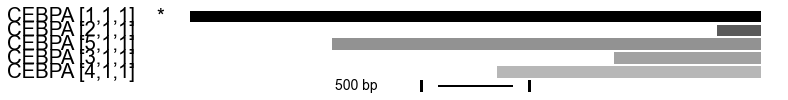

In [129]:
gene = 'CEBPA'
obs_col = 'sample'
obs_condition = 'hl60_m1_12hr'
ax, tpm_df = plot_browser_isos(ca, sg, gene,
                                         obs_col, obs_condition,
                                         filt_ab, major_set,
                                         h_space=0.24,
                                         h=0.2, ref_source='v40',
                                         major=False)

Calculating iso TPM values
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 234040
# isos >= 1 tpm: 212911
Applying gene type and novelty subset
Number of isos reported: 209476
Found 50 total samples
small text size: 20.3
big text size: 17.571194762684122


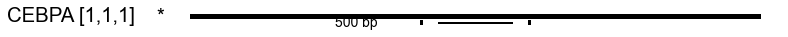

In [130]:
gene = 'CEBPA'
obs_col = 'sample'
obs_condition = 'hl60'
ax, tpm_df = plot_browser_isos(ca, sg, gene,
                                         obs_col, obs_condition,
                                         filt_ab, major_set,
                                         h_space=0.24,
                                         h=0.2, ref_source='v40',
                                         major=False)

## Which gene has the most diversity in terms of principal isoforms?

In [50]:
df = pd.read_csv('../swan/major_feats.tsv', sep='\t')
df.head()

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3427: DtypeWarning: Columns (0,19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


tid              gid              sample    tid_pi  \
0  ENSG00000285043[5,15,1]  ENSG00000285043               wtc11  95.81529   
1  ENSG00000285043[5,15,1]  ENSG00000285043             vessels  92.85714   
2  ENSG00000285043[5,15,1]  ENSG00000285043  pgp1_excite_neuron  81.53846   
3  ENSG00000285043[5,15,1]  ENSG00000285043           pgp1_endo  80.00000   
4  ENSG00000285043[5,15,1]  ENSG00000285043          pgp1_astro  85.31073   

   triplet_tpm       gid_stable             tss_id     tss_pi     tss_tpm  \
0   286.627000  ENSG00000285043  ENSG00000285043_5  96.392494  288.419980   
1   245.049710  ENSG00000285043  ENSG00000285043_5  93.095240  245.509500   
2    50.147280  ENSG00000285043  ENSG00000285043_5  83.076930   51.165703   
3    54.699585  ENSG00000285043  ENSG00000285043_5  80.000000   54.699585   
4   155.122470  ENSG00000285043  ENSG00000285043_5  85.875710  155.955410   

                ic_id     ic_pi      ic_tpm             tes_id      tes_pi  \
0  ENSG00000285043_15  96.82539  290.004360  ENSG00000285043_1   99.783554   
1  ENSG00000285043_15  94.64286  248.072740  ENSG00000285043_1  100.000000   
2  ENSG00000285043_15  81.53846   50.147280  ENSG00000285043_1  100.000000   
3  ENSG00000285043_15  80.00000   54.699585  ENSG00000285043_1  100.000000   
4  ENSG00000285043_15  85.31073  155.122470  ENSG00000285043_1  100.000000   

      tes_tpm            gname  tss  ic  tes triplet  
0  298.055240  ENSG00000285043    5  15    1  5,15,1  
1  265.761630  ENSG00000285043    5  15    1  5,15,1  
2   61.547830  ENSG00000285043    5  15    1  5,15,1  
3   67.684586  ENSG00000285043    5  15    1  5,15,1  
4  180.300810  ENSG00000285043    5  15    1  5,15,1

In [65]:
temp = df[['gid', 'gname', 'tid']].groupby(['gid', 'gname']).nunique().reset_index()

In [69]:
temp2 = df[['gid', 'gname', 'tid', 'sample']].groupby(['gid', 'gname', 'tid']).agg({'sample': ','.join}).reset_index()

In [66]:
temp.sort_values(by='tid', ascending=False)

gid     gname  tid
2987   ENSG00000105483     CARD8   17
3499   ENSG00000109339    MAPK10   17
5524   ENSG00000126746    ZNF384   17
7238   ENSG00000138640    FAM13A   17
9611   ENSG00000159023     EPB41   16
...                ...       ...  ...
7991   ENSG00000144015    TRIM43    0
1236   ENSG00000074855      ANO8    0
13188  ENSG00000179088  C12orf42    0
10996  ENSG00000166323  C11orf65    0
16123  ENSG00000225180    PVALEF    0

[16966 rows x 3 columns]

In [70]:
temp2.loc[temp2.gname=='MAPK10']

gid   gname                         tid  \
11631  ENSG00000109339  MAPK10      ENSG00000109339[1,1,2]   
11632  ENSG00000109339  MAPK10      ENSG00000109339[1,1,5]   
11633  ENSG00000109339  MAPK10     ENSG00000109339[1,38,5]   
11634  ENSG00000109339  MAPK10     ENSG00000109339[1,42,1]   
11635  ENSG00000109339  MAPK10     ENSG00000109339[1,44,5]   
11636  ENSG00000109339  MAPK10     ENSG00000109339[1,50,4]   
11637  ENSG00000109339  MAPK10     ENSG00000109339[1,54,5]   
11638  ENSG00000109339  MAPK10    ENSG00000109339[25,99,5]   
11639  ENSG00000109339  MAPK10  ENSG00000109339[35,194,41]   
11640  ENSG00000109339  MAPK10   ENSG00000109339[36,198,5]   
11641  ENSG00000109339  MAPK10   ENSG00000109339[36,199,5]   
11642  ENSG00000109339  MAPK10     ENSG00000109339[4,10,3]   
11643  ENSG00000109339  MAPK10     ENSG00000109339[4,73,5]   
11644  ENSG00000109339  MAPK10     ENSG00000109339[4,74,4]   
11645  ENSG00000109339  MAPK10     ENSG00000109339[4,78,5]   
11646  ENSG00000109339  MAPK10     ENSG00000109339[5,86,5]   
11647  ENSG00000109339  MAPK10     ENSG00000109339[6,14,3]   

                                                 sample  
11631                                    h9_panc_progen  
11632                                            ocily7  
11633                                                h1  
11634                                             imr90  
11635                                      h9_panc_beta  
11636                                             caco2  
11637  pgp1_excite_neuron,h9_neural_crest,adrenal gland  
11638                                      vessels,lung  
11639                                             brain  
11640                                             h1_de  
11641                                             h9_de  
11642                                             colon  
11643                           h9_osteocyte,h9_chondro  
11644                                             heart  
11645                                     ovary,adipose  
11646                                            kidney  
11647                           pgp1_astro,pgp1,gm12878

In [71]:
temp2.loc[temp2.gname=='CARD8']

gid  gname                       tid  \
9976  ENSG00000105483  CARD8    ENSG00000105483[1,1,2]   
9977  ENSG00000105483  CARD8    ENSG00000105483[1,1,4]   
9978  ENSG00000105483  CARD8    ENSG00000105483[1,1,6]   
9979  ENSG00000105483  CARD8   ENSG00000105483[1,10,7]   
9980  ENSG00000105483  CARD8   ENSG00000105483[1,11,3]   
9981  ENSG00000105483  CARD8   ENSG00000105483[1,37,4]   
9982  ENSG00000105483  CARD8   ENSG00000105483[1,38,2]   
9983  ENSG00000105483  CARD8    ENSG00000105483[1,8,2]   
9984  ENSG00000105483  CARD8    ENSG00000105483[1,8,6]   
9985  ENSG00000105483  CARD8    ENSG00000105483[1,9,7]   
9986  ENSG00000105483  CARD8   ENSG00000105483[3,33,7]   
9987  ENSG00000105483  CARD8   ENSG00000105483[3,35,7]   
9988  ENSG00000105483  CARD8   ENSG00000105483[3,36,2]   
9989  ENSG00000105483  CARD8    ENSG00000105483[3,7,2]   
9990  ENSG00000105483  CARD8    ENSG00000105483[3,7,4]   
9991  ENSG00000105483  CARD8  ENSG00000105483[6,15,12]   
9992  ENSG00000105483  CARD8   ENSG00000105483[9,32,7]   

                                                 sample  
9976                                      wtc11,hl60_m0  
9977                          ocily7,h9_panc_beta,h9_de  
9978                          vessels,imr90,hffc6,colon  
9979  pgp1,pc9,panc1,mcf7,mcf10a,hmec,hl60_m1_24hr,h...  
9980                                              heart  
9981  hl60_m2_72hr,h9_panc_progen,h9_osteocyte,h9_ch...  
9982  pgp1_excite_neuron,h9_neural_crest,h1_de,h1,brain  
9983                                              calu3  
9984                                     muscle,adipose  
9985                     pgp1_astro,caco2,adrenal gland  
9986                       pgp1_endo,huvec,hl60_m2_12hr  
9987                                       hl60_m1_12hr  
9988                                  lung,hl60_m1_72hr  
9989                                               hl60  
9990                                              liver  
9991                                             kidney  
9992                                  k562,hl60_m2_24hr

['v40' 'obs_det' 'sample_det' 'sample_det_centroid']


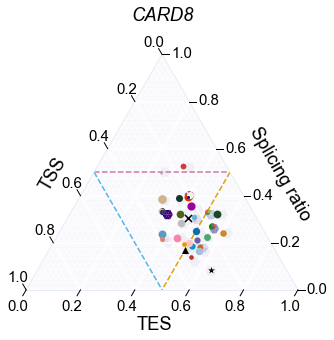

In [56]:
plot_simplex_here(ca, 'CARD8')

['v40' 'obs_det' 'sample_det' 'sample_det_centroid']


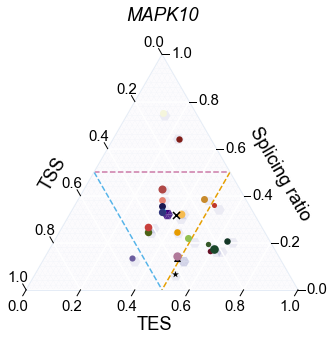

In [57]:
plot_simplex_here(ca, 'MAPK10')

## Compare how many isoforms in the observed set genes w/ high and low distances have

## GO on genes w/ high and low distances to their observed point

In [16]:
df = pd.read_csv('obs_vs_sample_det_centroid_dists.tsv', sep='\t')

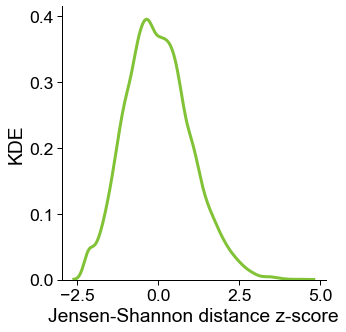

In [55]:
# calc z scores and use these to quantiy
sns.set_context('paper', font_scale=2)
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
df['z_score'] = st.zscore(df.dist.tolist())

ax = sns.displot(data=df, x='z_score', kind='kde', linewidth=3, color='#81c236')
xlabel = 'Jensen-Shannon distance z-score'
ylabel = 'KDE'
ax.set(xlabel=xlabel, ylabel=ylabel)
fname = f'{fig_dir}sample_det_centroid_vs_zscore_dist.pdf'
plt.savefig(fname, dpi=300)

In [18]:
z_hi = 2
z_low = -1
z_dict = {'high': z_hi, 'low': z_low}

2022-11-28 11:12:19,124 Error fetching enrichment results: GO_Biological_Process_2021
2022-11-28 11:12:22,950 Error fetching enrichment results: GO_Cellular_Component_2021
2022-11-28 11:12:27,009 Error fetching enrichment results: GO_Molecular_Function_2021
2022-11-28 11:12:30,845 Error fetching enrichment results: KEGG_2021_Human


0


2022-11-28 11:12:47,816 Error fetching enrichment results: GO_Biological_Process_2021
2022-11-28 11:12:54,069 Error fetching enrichment results: GO_Cellular_Component_2021
2022-11-28 11:12:59,882 Error fetching enrichment results: GO_Molecular_Function_2021
2022-11-28 11:13:05,754 Error fetching enrichment results: KEGG_2021_Human


285


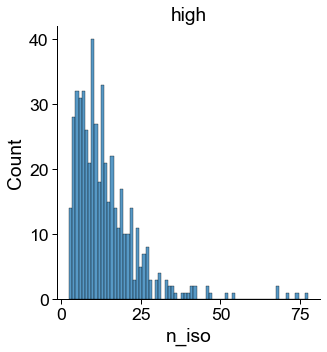

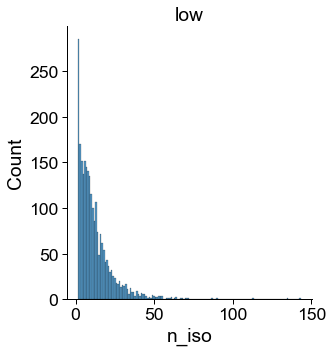

In [19]:
# get # isos from obs_det for each gene in each set
for key, item in z_dict.items():
    if key == 'high':
        gids = df.loc[df.z_score >= item, 'gid'].tolist()
    elif key == 'low':
        # don't consider genes w/ just one isos
        gids = df.loc[df.z_score <= item, 'gid'].tolist()
    temp = ca.triplets.loc[(ca.triplets.source=='obs_det')&(ca.triplets.gid.isin(gids))]
    temp = temp.loc[temp.n_iso > 1]
    gids = temp.gid.tolist()
    
    # GO
    dbs = ['GO_Biological_Process_2021',
    'GO_Cellular_Component_2021',
    'GO_Molecular_Function_2021',
    'KEGG_2021_Human']
    bm = gp.parser.Biomart()
    datasets = bm.get_datasets(mart='ENSEMBL_MART_ENSEMBL')
    datasets.loc[datasets.Description.str.contains('Human')]
    desc = '{} genes'.format(key)
    odir = 'obs_v_sample_det_{}_dist_genes_GO'.format(key)
    gids = bm.query(dataset='hsapiens_gene_ensembl',
                    attributes=['ensembl_gene_id', 'external_gene_name'],
                    filters={'ensembl_gene_id': gids})
    gids = gids.loc[~gids.external_gene_name.isna()]
    gnames = gids.external_gene_name.squeeze().str.strip().tolist()
    go = gp.enrichr(gene_list=gnames,
                    gene_sets=dbs,
                    organism='Human',
                    description=desc,
                    outdir=odir,
                    cutoff=0.5)
    
    print(len(temp.loc[temp.n_iso == 2]))
    ax = sns.displot(temp, x='n_iso', discrete=True)
    ax.set(title=key)

## Compare overall distribution of triplet features / gene w/ sample-level dists

In [13]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import pdb
import copy
from scipy import sparse
import anndata
import cerberus
import subprocess
from pandarallel import pandarallel

p = os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

In [14]:
major_set = '../swan/isos_sample_gene_90.tsv'
c_annot = 'cerberus_annot_triplets.h5'
gtf = '../cerberus.gtf'
swan_file = '../swan/swan.p'
filt_ab = '../cerberus_filtered_abundance.tsv'
h5 = '../cerberus_annot.h5'
feat = 'tss'
obs_source = 'lapa'
ref_sources = ['v40', 'v29']

fig_dir = '/Users/fairliereese/mortazavi_lab/documents/rnawg/fig_obs_vs_sample_det_centroid/'

In [15]:
sg = swan.read(swan_file)
ca = cerberus.read(c_annot)

Read in graph from ../swan/swan.p


In [16]:
def get_counts_per_gene(filt_ab, obs_col, feat, min_tpm, gene_subset):
    # counts per gene
    df = pd.read_csv(filt_ab, sep='\t')
    df = get_det_table(df,
                        groupby=obs_col,
                        how=feat, 
                        gene_subset=gene_subset,
                        min_tpm=min_tpm)

    df = df.transpose()
    df.reset_index(inplace=True)
    df.rename({'index':'feat_id'}, axis=1, inplace=True)
    if feat in ['tss', 'ic', 'tes']:
        df['gid'] = df.feat_id.str.split('_', expand=True)[0]
    else:
        df['gid'] = df.feat_id.str.split('[', expand=True)[0]
    df = df[['gid', 'feat_id']].groupby('gid').count().reset_index()
    df.rename({'feat_id': 'counts'}, axis=1, inplace=True)
    
    return df

In [17]:
def get_counts_per_sample_per_gene(filt_ab, obs_col, feat, min_tpm, gene_subset):
    
    # counts per sample per gene
    df = pd.read_csv(filt_ab, sep='\t')
    df = get_det_table(df,
                        groupby=obs_col,
                        how=feat, 
                        gene_subset=gene_subset,
                        min_tpm=min_tpm)

    df = df.melt(var_name='feat_id', value_name='det', ignore_index=False)
    df.reset_index(inplace=True)
    df.rename({'index': obs_col}, axis=1, inplace=True)
    df = df.loc[df.det == True]
    df.drop('det', axis=1, inplace=True)

    if feat in ['tss', 'ic', 'tes']:
        df['gid'] = df.feat_id.str.split('_', expand=True)[0]
    else:
        df['gid'] = df.feat_id.str.split('[', expand=True)[0]
    df = df.groupby(['biosample', 'gid']).count().reset_index()
    df.rename({'feat_id': 'counts'}, axis=1, inplace=True)
    
    return df

In [26]:
def plot_feats_per_sample_gene(temp, feat):
    sns.set_context('paper', font_scale=2)
    mpl.rcParams['font.family'] = 'Arial'
    mpl.rcParams['pdf.fonttype'] = 42

    if feat in ['tss', 'tes', 'ic']:
        x_hr = feat.upper()
    elif feat == 'iso':
        x_hr = 'isoform'
    c_dict, order = get_feat_triplet_colors_2(feat)
    color = c_dict[feat]
    
    # get each df
    temp1 = temp.loc[temp.source == 'Sample']
    temp1, order, col = renum_max_feats(temp1, 'counts', 10)
    temp1 = temp1[[col, 'biosample', 'gid']].groupby([col, 'biosample']).count().reset_index()
    temp1.rename({'gid': 'n_feats'}, axis=1, inplace=True)
    temp1_max = temp1['n_feats'].max()
    
    temp2 = temp.loc[temp.source == 'Observed']
    temp2, order, col = renum_max_feats(temp2, 'counts', 10)
    temp2 = temp2[[col, 'gid']].groupby([col]).count().reset_index()
    temp2.rename({'gid': 'n_feats'}, axis=1, inplace=True)
    temp2_max = temp2['n_feats'].max()
    
    ymax = max(temp1_max, temp2_max)
    ylim = (0, ymax)
    
    # feats / sample / gene
    ax = sns.catplot(data=temp1, y='n_feats', x=col, kind='bar',
                     edgecolor=None, saturation=1,
                     alpha=1, color=color, order=order)
    xlabel = f'# {x_hr}s / gene / {obs_col}'
    ylabel = '# genes'
    ax.set(xlabel=xlabel, ylabel=ylabel, ylim=ylim)
    fname = f'{fig_dir}/{feat}_gene_sample_hist.pdf'
    plt.savefig(fname, dpi=500)

    # observed overall feats / gene
    plt.figure(figsize=(3,4))
    ax = sns.catplot(data=temp2, y='n_feats', x=col, kind='bar',
                     edgecolor=None, saturation=1,
                     alpha=1, color=color, order=order)
    xlabel = f'# {x_hr}s / gene'
    ylabel = '# genes'
    ax.set(xlabel=xlabel, ylabel=ylabel, ylim=ylim)
    fname = f'{fig_dir}/{feat}_gene_hist.pdf'
    plt.savefig(fname, dpi=500)


In [27]:
def plot_feats_per_sample_gene_ecdf(temp, feat):
    from matplotlib.lines import Line2D

    c_dict, order = get_feat_triplet_colors_2(feat)
    color = c_dict[feat]

    plt.figure(figsize=(4,4))
    temp1 = temp.loc[temp.source=='Observed']
    ax = sns.ecdfplot(data=temp1, x='counts', color=color, linewidth=3, linestyle='--')
    temp1 = temp.loc[temp.source=='Sample']
    ax = sns.ecdfplot(data=temp1, x='counts', color=color, linewidth=3)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    legend_elements = [Line2D([0], [0], color=color, lw=3, label='Sample'),
                       Line2D([0], [0], color=color, lw=3, linestyle='--', label='Observed')]
    ax.legend(handles=legend_elements)

    x_hr = feat.upper()
    if feat in ['tss', 'ic', 'tes']:
        xlabel_thing = f'# {x_hr}s'
    elif feat == 'iso':
        xlabel_thing = 'isoforms'
    xlabel = f'# {xlabel_thing} / gene'
    _ = ax.set(xlabel=xlabel)

    fname = f'{fig_dir}/{feat}_gene_sample_ecdf.pdf'
    plt.savefig(fname, dpi=500)

In [28]:
def renum_max_feats(temp, col, max_val):
    """
    Parameters:
        temp (df): DataFrame
        col (str): Col to transform
        max_val (int): Max value
    """
    max_str = '{}+'.format(max_val)
    temp['rank'] = temp[col].astype(int).astype(str)
    temp.loc[temp[col]>=max_val, 'rank'] = max_str
    order = [str(int(i)) for i in range(1,max_val)]
    order += [max_str]
    return temp, order, 'rank'

In [29]:
def perc(n_num, n):
    return (n_num/n)*100

In [30]:
def plot_perc_one_feat(df, feat, opref='figures/'):
    sns.set_context('paper', font_scale=2)
    mpl.rcParams['font.family'] = 'Arial'
    mpl.rcParams['pdf.fonttype'] = 42
    plt.figure(figsize=(2,4))

    c_dict, order = get_feat_triplet_colors_2(feat)
    color = c_dict[feat]
    
    if feat in ['tss', 'ic', 'tes']:
        ylabel = f'% genes with 1 {feat.upper()}'
    elif feat == 'iso':
        ylabel = '% genes with 1 isoform'
    order = ['Gene', 'Gene / sample']
    ax = sns.barplot(df, y='perc', x='combo', color=color, order=order, saturation=1)
    ax.set(ylim=(0, 100), ylabel=ylabel, xlabel='')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    _ = plt.setp(ax.get_xticklabels(), rotation=90)
    
    fname = f'{opref}/perc_genes_one_{feat}.pdf'
    plt.savefig(fname, dpi=500, bbox_inches='tight')

In [31]:
def get_n_samples_vs_n_feats(df):
    """
    Compute how many samples each feature is expressed in
    """
    temp = df.copy(deep=True)
    
    # compute how many samples each gene is expressed in 
    temp1 = temp.loc[temp.source=='Sample']
    temp1 = temp1[['gid', 'biosample']].groupby('gid').count().reset_index()
    temp1.rename({'biosample':'n_samples'}, axis=1, inplace=True)
    temp1.head()
    
    temp2 = temp.loc[temp.source=='Observed'].drop('biosample', axis=1)
    temp2 = temp2.merge(temp1, on='gid', how='left')
    temp2.head()
    
    return temp2

In [34]:
def plot_n_samples_vs_n_feats(temp, feat, opref):
    c_dict, order = get_feat_triplet_colors_2(feat)
    color = c_dict[feat]
    
    df = get_n_samples_vs_n_feats(temp)
    # ax = sns.jointplot(df, x='n_samples', y='counts', color=color, marginal_kws={'discrete':True, 'edgecolor':None}, joint_kws={'alpha':0.25, 's':10})
    ax = sns.jointplot(df, x='n_samples', y='counts', kind='hex', color=color, marginal_kws={'discrete':True, 'edgecolor':None},
                       joint_kws={'edgecolors':'none', 'bins':'log', 'mincnt':0})

    ylabel = '# observed '
    if feat in ['tss', 'ic', 'tes']:
        ylabel += f'{feat.upper()}s'
    elif feat == 'iso':
        ylabel += 'isoforms'
    xlabel = '# samples'
    
    ax.ax_joint.set(xlabel=xlabel, ylabel=ylabel)
    
    fname = f'{opref}/n_{feat}s_per_n_samples_expressed.pdf'
    plt.savefig(fname, dpi=500, bbox_inches='tight')

Calculating iso TPM values
Subsetting for protein_coding genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1854: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1853: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # isos detected: 234040
# isos >= 1 tpm: 212911
Applying gene type and novelty subset
Number of isos reported: 190547
Found 50 total samples
Calculating iso TPM values
Subsetting for protein_coding genes
Enforcing minimum TPM
Total # isos detected: 234040
# isos >= 1 tpm: 212911
Applying gene type and novelty subset
Number of isos reported: 190547
Found 50 total samples
10.18% (1783/17523)of genes have just 1 iso
24.28% (132458/545554)of gene / sample combos have just 1 iso
iso ks test statistic: 0.3854477679416198, pval: 0.0

Calculating tss TPM values
Subsetting for protein_coding genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1854: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1853: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # tsss detected: 76487
# tsss >= 1 tpm: 67730
Applying gene type and novelty subset
Number of tsss reported: 53051
Found 50 total samples
Calculating tss TPM values
Subsetting for protein_coding genes
Enforcing minimum TPM
Total # tsss detected: 76487
# tsss >= 1 tpm: 67730
Applying gene type and novelty subset
Number of tsss reported: 53051
Found 50 total samples
26.56% (4656/17527)of genes have just 1 tss
60.18% (330141/548595)of gene / sample combos have just 1 tss
tss ks test statistic: 0.3613646681376286, pval: 0.0

Calculating ic TPM values
Subsetting for protein_coding genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1854: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1853: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # ics detected: 149009
# ics >= 1 tpm: 135190
Applying gene type and novelty subset
Number of ics reported: 117399
Found 50 total samples
Calculating ic TPM values
Subsetting for protein_coding genes
Enforcing minimum TPM
Total # ics detected: 149009
# ics >= 1 tpm: 135190
Applying gene type and novelty subset
Number of ics reported: 117399
Found 50 total samples
15.14% (2653/17523)of genes have just 1 ic
29.83% (162769/545717)of gene / sample combos have just 1 ic
ic ks test statistic: 0.3069209214735752, pval: 0.0

Calculating tes TPM values
Subsetting for protein_coding genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1854: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1853: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # tess detected: 88726
# tess >= 1 tpm: 78398
Applying gene type and novelty subset
Number of tess reported: 62015
Found 50 total samples
Calculating tes TPM values
Subsetting for protein_coding genes
Enforcing minimum TPM
Total # tess detected: 88726
# tess >= 1 tpm: 78398
Applying gene type and novelty subset
Number of tess reported: 62015
Found 50 total samples
21.82% (3824/17525)of genes have just 1 tes
48.59% (266236/547881)of gene / sample combos have just 1 tes


/Users/fairliereese/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/fairliereese/miniconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:447: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)
/Users/fairliereese/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may

tes ks test statistic: 0.3550186234955105, pval: 0.0



/Users/fairliereese/miniconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1690: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(height, height))


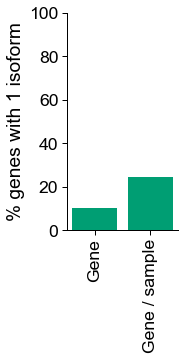

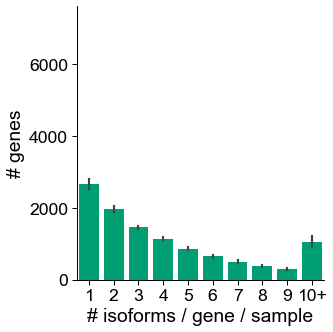

<Figure size 216x288 with 0 Axes>

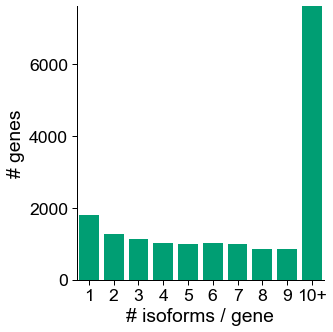

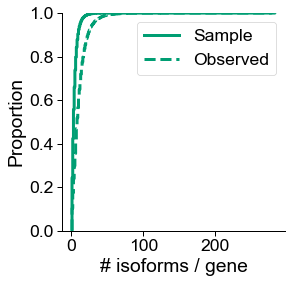

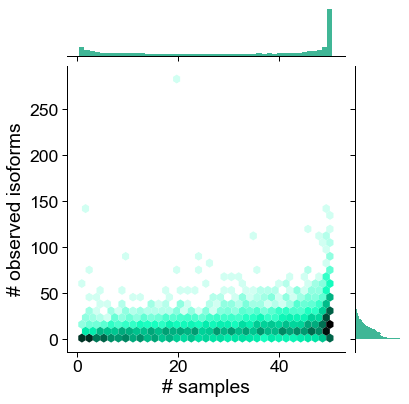

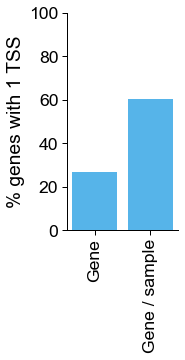

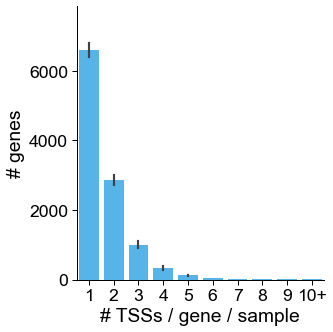

<Figure size 216x288 with 0 Axes>

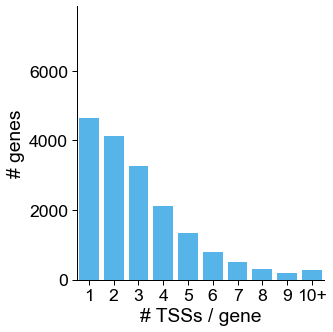

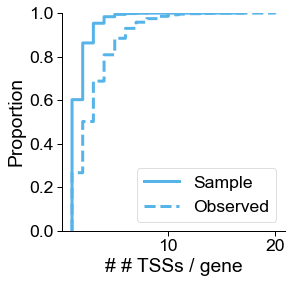

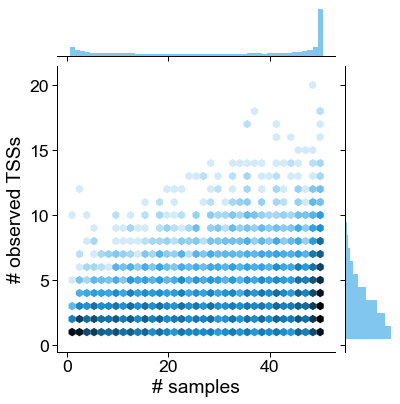

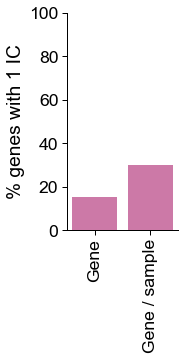

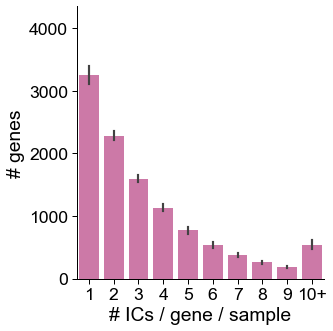

<Figure size 216x288 with 0 Axes>

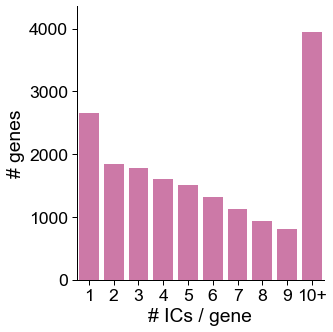

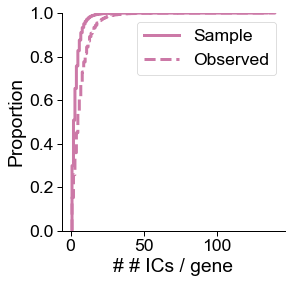

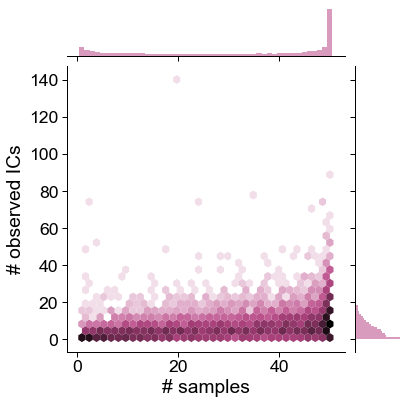

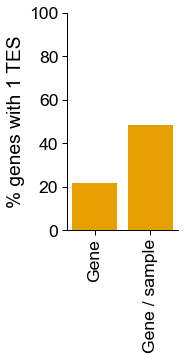

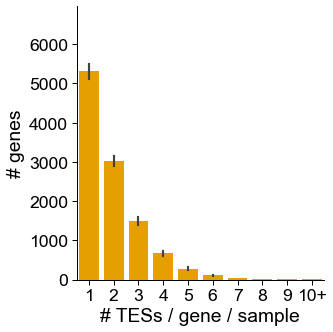

<Figure size 216x288 with 0 Axes>

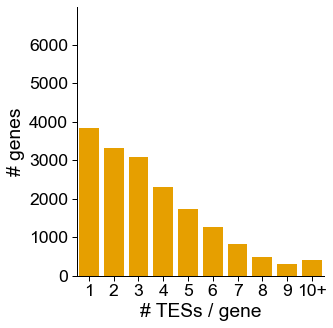

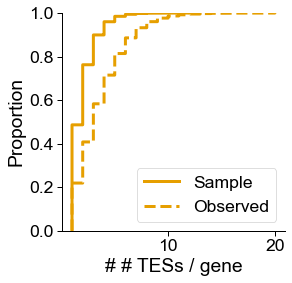

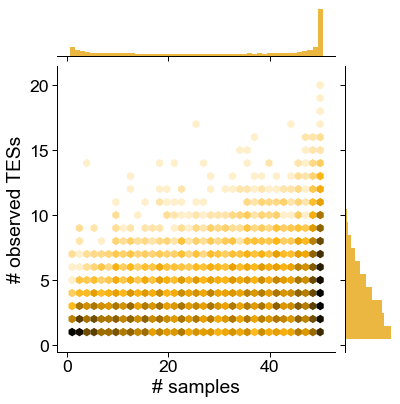

In [35]:
obs_col = 'sample'
min_tpm = 1
gene_subset = 'protein_coding'

feat_sample = pd.DataFrame()
df = pd.DataFrame()
for feat in ['iso', 'tss', 'ic', 'tes']:

    # these won't give the exact same values / gene as the triplets because we're looking
    # at the expression of individual features. But to be consistent with what's done 
    # to generate the plots earlier in the paper this is how we should do it
    g_counts = get_counts_per_gene(filt_ab, obs_col, feat, min_tpm, gene_subset)
    gs_counts = get_counts_per_sample_per_gene(filt_ab, obs_col, feat, min_tpm, gene_subset)
    
    g_counts['source'] = 'Observed'
    g_counts['feat'] = feat
    gs_counts['source'] = 'Sample'
    gs_counts['feat'] = feat
    
    # what % of genes only have 1 triplet feat?
    n_num = len(g_counts.loc[g_counts.counts==1].index)
    n = len(g_counts.index)
    p_g = perc(n_num, n)
    print(f'{p_g:.2f}% ({n_num}/{n})of genes have just 1 {feat}')
    
    # what % of gene / sample combos only have 1 triplet feat?
    n_num = len(gs_counts.loc[gs_counts.counts==1].index)
    n = len(gs_counts.index)
    p_gs = perc(n_num, n)
    print(f'{perc(n_num,n):.2f}% ({n_num}/{n})of gene / sample combos have just 1 {feat}')
    temp1 = pd.DataFrame()
    temp1['combo'] = ['Gene', 'Gene / sample'] 
    temp1['perc'] = [p_g, p_gs]
    temp1['feat'] = feat
    plot_perc_one_feat(temp1, feat, opref=fig_dir)
        
    temp = pd.concat([g_counts, gs_counts], axis=0)    
    
    # # remove genes that only have 1 isoform overall
    # gids = ca.triplets.loc[(ca.triplets.source=='obs_det')&(ca.triplets.n_iso>1), 'gid'].unique().tolist()
    # print(len(temp.index))
    # temp = temp.loc[temp.gid.isin(gids)]
    # print(len(temp.index))
    
    # make plots
    
    plot_feats_per_sample_gene(temp, feat)
    plot_feats_per_sample_gene_ecdf(temp, feat)
    
    # test for differences
    obs = np.array(temp.loc[temp.source=='Observed', 'counts'].tolist())
    samp = np.array(temp.loc[temp.source=='Sample', 'counts'].tolist())
    
    s, pval = stats.kstest(obs, samp, alternative='two-sided')
    print(f'{feat} ks test statistic: {s}, pval: {pval}')
    print()
    
    # make an aggregate dataframe across the feats for n_feats vs. n_samples
    # feat_sample = pd.concat([feat_sample, get_n_samples_vs_n_feats(temp)], axis=0)
    plot_n_samples_vs_n_feats(temp, feat, opref=fig_dir)
    
    df = pd.concat([df, temp], axis=0)   

## KS-test on obs_det vs. one sample at a time

In [9]:
ca = cerberus.read(c_annot)

In [ ]:
obs_col = 'sample'
min_tpm = 1
gene_subset = 'protein_coding'

df = pd.DataFrame()
for feat in ['tss', 'ic', 'tes', 'iso']:

    # these won't give the exact same values / gene as the triplets because we're looking
    # at the expression of individual features. But to be consistent with what's done 
    # to generate the plots earlier in the paper this is how we should do it
    g_counts = get_counts_per_gene(filt_ab, obs_col, feat, min_tpm, gene_subset)
    gs_counts = get_counts_per_sample_per_gene(filt_ab, obs_col, feat, min_tpm, gene_subset)
    
    g_counts['source'] = 'Observed'
    g_counts['feat'] = feat
    gs_counts['source'] = 'Sample'
    gs_counts['feat'] = feat
    
    # remove genes that only have 1 isoform overall
    temp = pd.concat([g_counts, gs_counts], axis=0)
    # gids = ca.triplets.loc[(ca.triplets.source=='obs_det')&(ca.triplets.n_iso>1), 'gid'].unique().tolist()
    # print(len(temp.index))
    # temp = temp.loc[temp.gid.isin(gids)]
    # print(len(temp.index))
    
    # loop through samples
    for s in gs_counts.biosample.unique().tolist():

        # test for differences
        obs = np.array(temp.loc[temp.source=='Observed', 'counts'].tolist())
        samp = np.array(temp.loc[(temp.source=='Sample')&(temp.biosample==s), 'counts'].tolist())
        
        s, pval = stats.kstest(obs, samp, alternative='two-sided')
        print(f'{s}: {feat} ks test statistic: {s}, pval: {pval}')
        print()

## Sankey plot of sector from obs det to sample_det centroid

In [23]:
df = pd.read_csv('obs_vs_sample_det_centroid_dists.tsv', sep='\t')

In [24]:
# sample det
df_samp = df[['gid', 'tss_ratio_det', 'tes_ratio_det', 'spl_ratio_det', 'n_iso_det']]
r_map = dict([(c, c.rsplit('_', maxsplit=1)[0]) for c in df_samp.columns if 'det' in c])
df_samp.rename(r_map, axis=1, inplace=True)
df_samp = assign_sector(df_samp)
df_samp['source'] = 'sample_det_centroid'

# obs
df_obs = df[['gid', 'tss_ratio_obs_det', 'tes_ratio_obs_det', 'spl_ratio_obs_det', 'n_iso_obs_det']]
r_map = dict([(c, c.rsplit('_', maxsplit=2)[0]) for c in df_obs.columns if 'obs' in c])
df_obs.rename(r_map, axis=1, inplace=True)
df_obs = assign_sector(df_obs)
df_obs['source'] = 'obs_det'


df = df_obs.merge(df_samp, on='gid', suffixes=('_obs_det', '_sample_det_centroid'))

In [25]:
# count the number of genes from obs_det -> sample_det_centroid for each 
df = df[['gid', 'sector_obs_det', 'sector_sample_det_centroid']].groupby(['sector_obs_det', 'sector_sample_det_centroid']).count().reset_index()
df.rename({'gid': 'n_genes'}, axis=1, inplace=True)

In [26]:
# import random
# temp = df.copy(deep=True)
# temp['n_genes'] = [random.randint(1,12000) for i in range(len(temp.index))]

# ofile = 'figures/test_sankey.pdf'
# fig = plot_sankey(temp,
#               source='sector_obs_det',
#               sink='sector_sample_det_centroid',
#               counts='n_genes',
#               color='sector',
#               title='')
# pio.write_image(fig, ofile, width=700, height=900)  

{'tss': '#56B4E9', 'splicing': '#CC79A7', 'tes': '#E69F00', 'simple': '#000000', 'mixed': '#b7b7b7'}
{'label': ['TSS', 'Splicing', 'TES', 'Mixed', 'Simple', 'TSS', 'Splicing', 'TES', 'Mixed', 'Simple'], 'color': ['#56B4E9', '#CC79A7', '#E69F00', '#b7b7b7', '#000000', '#56B4E9', '#CC79A7', '#E69F00', '#b7b7b7', '#000000'], 'x': [0.01, 0.01, 0.01, 0.01, 0.01, 1.0, 1.0, 1.0, 1.0, 1.0], 'y': [0.01, 0.25, 0.5, 0.75, 1.0, 0.01, 0.25, 0.5, 0.75, 1.0]}


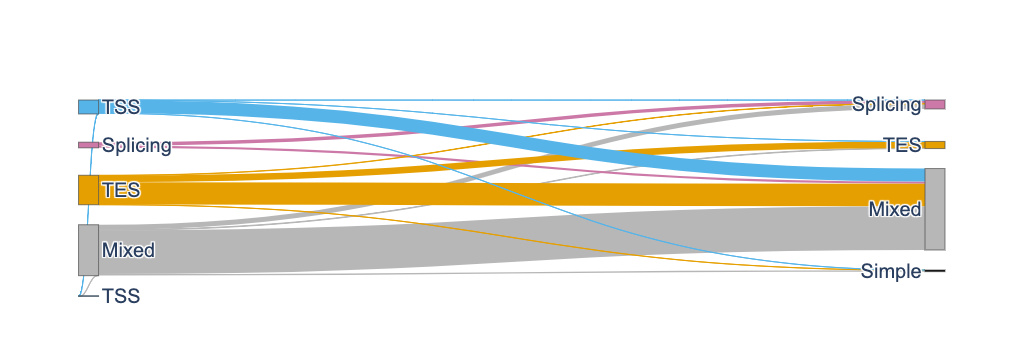

In [28]:
ofile = 'figures/sankey_obs_det_vs_sample_det_centroid.pdf'
fig = plot_sankey(df,
              source='sector_obs_det',
              sink='sector_sample_det_centroid',
              counts='n_genes',
              color='sector',
              title='')
pio.write_image(fig, ofile, width=700, height=900)  


In [29]:
df.groupby('sector_obs_det').sum().reset_index()

sector_obs_det  n_genes  source  sink
0          mixed     8012      15    35
1       splicing      888       2    14
2            tes     4641       8    30
3            tss     2197       0    35

In [30]:
df.groupby('sector_sample_det_centroid').sum().reset_index()

sector_sample_det_centroid  n_genes  source  sink
0                      mixed    12815       6    32
1                     simple      262       5    27
2                   splicing     1406       6    24
3                        tes     1123       5    21
4                        tss      132       3    10

In [31]:
df.loc[df.sector_obs_det==df.sector_sample_det_centroid]

sector_obs_det sector_sample_det_centroid  n_genes  source  sink
0           mixed                      mixed     6900       3     8
6        splicing                   splicing      547       1     6
10            tes                        tes     1040       2     7
15            tss                        tss      113       0     5

In [34]:
df['same_sect'] = df.sector_obs_det == df.sector_sample_det_centroid
df = df[['same_sect', 'sector_obs_det', 'n_genes']].groupby(['sector_obs_det', 'same_sect']).sum()
df.reset_index(inplace=True)
df

n_genes
sector_obs_det same_sect         
mixed          False         1112
               True          6900
splicing       False          341
               True           547
tes            False         3601
               True          1040
tss            False         2084
               True           113

In [35]:
df.reset_index(inplace=True)
df

sector_obs_det  same_sect  n_genes
0          mixed      False     1112
1          mixed       True     6900
2       splicing      False      341
3       splicing       True      547
4            tes      False     3601
5            tes       True     1040
6            tss      False     2084
7            tss       True      113

In [37]:
temp = df[['sector_obs_det', 'n_genes']].groupby('sector_obs_det').sum().reset_index()
temp.rename({'n_genes': 'n_total_genes'}, axis=1, inplace=True)
df = df.merge(temp, on='sector_obs_det')
df['perc'] = df.n_genes/df.n_total_genes

In [39]:
df.loc[df.same_sect ==False]

sector_obs_det  same_sect  n_genes  n_total_genes      perc
0          mixed      False     1112           8012  0.138792
2       splicing      False      341            888  0.384009
4            tes      False     3601           4641  0.775910
6            tss      False     2084           2197  0.948566